In [2]:
import numpy as np
import awkward as ak
import uproot

import hist
from topcoffea.modules.histEFT import HistEFT
import topcoffea.modules.utils as utils

import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [3]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [4]:
hep.style.use("CMS")
params = {'axes.labelsize': 20,
          'axes.titlesize': 20,
          'legend.fontsize':20, 
          'lines.markersize':5}
plt.rcParams.update(params)

cmap = mpl.colormaps["tab10"]  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

In [38]:
wc_lst = utils.get_list_of_wc_names("/cms/cephfs/data/store/user/hnelson2/mc/NanoGen/tWLO_SMEFTsimtop/NanoGen_tWLO_rwgt1/nanoGen_376.root")
print(wc_lst)

['cleQt1Re33', 'cleQt1Re11', 'cleQt3Re22', 'cleQt1Re22', 'cQl333', 'cQl322', 'cleQt3Re33', 'cQl311', 'ctGRe', 'ctGIm', 'cleQt3Re11', 'cHQ3', 'ctWRe', 'cbWRe', 'cHtbRe']


# Event Weight Plots

In [6]:
# utils.get_hist_from_pkl("", allow_empty=False)

tWLO_stpt1_weights = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt1_weights.pkl.gz", allow_empty=False)
tWLO_stpt2_weights = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt2_weights.pkl.gz", allow_empty=False)

In [7]:
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/event_weights"

weight_plots = {"tWLO_stpt1_event_weights":tWLO_stpt1_weights, "tWLO_stpt2_event_weights":tWLO_stpt2_weights}

for hists in weight_plots: 
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color=colors)
    for h in weight_plots[hists]:
        hep.histplot(weight_plots[hists][h], ax=ax, stack=False, yerr=True, linewidth=2, label=h[:-4][8:])
    ax.set_xlabel("log(event weight)")
    ax.set_ylabel("Counts")
    ax.set_xlim([-2.5,0.01])
    ax.legend(loc='upper right')
    outname=os.path.join(outpath, f"{hists}.png")
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/event_weights/tWLO_stpt1_event_weights.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/event_weights/tWLO_stpt2_event_weights.png


# Kinematic Plots with Uncertainties

In [21]:
def get_ratio_uncertainty(num_hist, denom_hist):
    xvals = num_hist.axes.centers[0]
    yvals_num = num_hist.values()
    yvals_denom = denom_hist.values()
    sigma_num = np.sqrt(num_hist.variances())
    sigma_denom = np.sqrt(denom_hist.variances())

    ratio = np.divide(yvals_num, yvals_denom)

    # calculation for error propagation for ratio = yavls_num/yvals_denom
    # generally, z=x/y; sigma_z = abs(z)sqrt((sigma_x/x)^2+(sigma_y/y)^2)
    sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))

    return sigma_y

def get_ratio_points(hist1, histSM):
    num = hist1.values()
    centers = hist1.axes.centers[0]
    denomSM = histSM.values()
    ratio = np.divide(num, denomSM)

    return centers, ratio

def make_plot_with_ratio(h_num, h_denom, label_num, label_denom, xlabel, title, color1='tab:blue', color2='tab:orange'):
    ## get ratios and uncertainties
    centers, ratio = get_ratio_points(h_num, h_denom)
    uncert = get_ratio_uncertainty(h_num, h_denom)

    ## Initialize figure and axes
    # fig, ax = plt.subplots()
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    ## Plot histograms and ratio plot
    # color='tab:blue'
    # color='tab:orange'
    hep.histplot(h_num, ax=ax, stack=False, yerr=True, linewidth=2, label=label_num, color=color1)
    hep.histplot(h_denom, ax=ax, stack=False, yerr=True, linewidth=2, label=label_denom, color=color2)
    rax.scatter(centers, ratio, color=color1)
    rax.errorbar(centers, ratio, xerr = None, yerr = uncert, capsize=5, ls='none', color=color1)

    ## Formatting
    ax.legend(loc = 'upper right', fontsize = 'small')
    ax.set_ylabel("Events", fontsize='medium')
    ax.set_xlabel("")
    rax.set_ylabel("Ratio", fontsize='medium')
    rax.set_xlabel(xlabel, fontsize="medium")
    rax.set_ylim([0, 2])
    rax.axhline(y=1.0, color='gray', linestyle='--')
    # rax.grid(axis='y')
    plt.figtext(0.13, 0.9, title, fontsize='small')

    return fig, ax, rax

def make_plot_2samples_with_ratio(h_num1, h_num2, h_denom, label_num1, label_num2, label_denom, xlabel, title):
    ## get ratios and uncertainties
    centers1, ratio1 = get_ratio_points(h_num1, h_denom)
    uncert1 = get_ratio_uncertainty(h_num1, h_denom)
    
    centers2, ratio2 = get_ratio_points(h_num2, h_denom)
    uncert2 = get_ratio_uncertainty(h_num2, h_denom)

    ## Initialize figure and axes
    # fig, ax = plt.subplots()
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    ## Plot histograms and ratio plot
    hep.histplot(h_num1, ax=ax, stack=False, yerr=True, linewidth=2, label=label_num1)
    hep.histplot(h_num2, ax=ax, stack=False, yerr=True, linewidth=2, label=label_num2)
    hep.histplot(h_denom, ax=ax, stack=False, yerr=True, linewidth=2, label=label_denom)
    rax.scatter(centers1, ratio1)
    rax.errorbar(centers1, ratio1, xerr = None, yerr = uncert1, capsize=5, ls='none')
    rax.scatter(centers2, ratio2)
    rax.errorbar(centers2, ratio2, xerr = None, yerr = uncert2, capsize=5, ls='none')

    ## Formatting
    ax.legend(loc = 'upper right', fontsize = 'small')
    ax.set_ylabel("Events", fontsize='medium')
    ax.set_xlabel("")
    rax.set_ylabel("Ratio", fontsize='medium')
    rax.set_xlabel(xlabel, fontsize="medium")
    rax.set_ylim([0, 2])
    rax.axhline(y=1.0, color='gray', linestyle='--')
    # rax.grid(axis='y')
    plt.figtext(0.13, 0.9, title, fontsize='small')

    return fig, ax, rax

In [9]:
## do this when the normalization is just xsec/sow to find what constant is needed to normalize all hists in this sample to 1.0
tWLO_stpt1_kin = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt1_kin.pkl.gz", allow_empty=False)
tWLO_stpt2_kin = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt2_kin.pkl.gz", allow_empty=False)
tWtop_kin = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWtop_powheg_kin.pkl.gz", allow_empty=False)
tWantitop_kin = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWantitop_powheg_kin.pkl.gz", allow_empty=False)

# pkl_files = [tWLO_stpt1_kin, tWLO_stpt2_kin, tWtop_kin, tWantitop_kin]
pkl_files = [tWtop_kin, tWantitop_kin]
for hists in pkl_files: 
    print(f"\n {namestr(hists, globals())[1]}.pkl.gz")
    for h in hists:
        print(f"    {h}:{hists[h].sum()}")


 tWtop_kin.pkl.gz
    njets:WeightedSum(value=0.92038, variance=2.11741e-05)
    nleps:WeightedSum(value=0.92038, variance=2.11741e-05)
    ntops:WeightedSum(value=0.92038, variance=2.11741e-05)
    mll:WeightedSum(value=0.919922, variance=2.11615e-05)
    dr_leps:WeightedSum(value=0.92038, variance=2.11741e-05)
    l0pt:WeightedSum(value=0.91818, variance=2.11174e-05)
    top_pt:WeightedSum(value=0.919694, variance=2.11562e-05)
    mt2:WeightedSum(value=0.920357, variance=2.11735e-05)

 tWantitop_kin.pkl.gz
    njets:WeightedSum(value=0.924623, variance=2.32421e-05)
    nleps:WeightedSum(value=0.924623, variance=2.32421e-05)
    ntops:WeightedSum(value=0.924623, variance=2.32421e-05)
    mll:WeightedSum(value=0.924273, variance=2.32321e-05)
    dr_leps:WeightedSum(value=0.924623, variance=2.32421e-05)
    l0pt:WeightedSum(value=0.922496, variance=2.31876e-05)
    top_pt:WeightedSum(value=0.923898, variance=2.3224e-05)
    mt2:WeightedSum(value=0.924623, variance=2.32421e-05)


In [10]:
tWtop = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWtop_powheg_kin_norm.pkl.gz", allow_empty=False)
tWantitop = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWantitop_powheg_kin_norm.pkl.gz", allow_empty=False)
tWLO_stpt1 = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt1_kin_norm.pkl.gz", allow_empty=False)
tWLO_stpt2 = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt2_kin_norm.pkl.gz", allow_empty=False)

In [22]:
#### Make plots for tWLO_stpt1 sample 
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/"
for name in tWtop: 
    hpowheg = tWtop[name]+tWantitop[name]
    hEFT = tWLO_stpt1[name]
    fig, ax, rax = make_plot_with_ratio(hEFT, hpowheg, "tW_EFT(stpt1)", "tW_powheg", name, "Reweighted to SM, normalized to 1.0", color1='tab:blue', color2='tab:red')
    outname = os.path.join(outpath, f"{name}.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)

# make mt2 plot with the right bounds for SM reweight point 
name='mt2'
hpowheg = tWtop[name]+tWantitop[name]
hEFT = tWLO_stpt1[name]
fig, ax, rax = make_plot_with_ratio(hEFT, hpowheg, "tW_EFT(stpt1)", "tW_powheg", name, "Reweighted to SM, normalized to 1.0", color1='tab:blue', color2='tab:red')
ax.set_xlim([0,125])
outname = os.path.join(outpath, f"{name}.png")    
fig.savefig(outname)
print(f'plot saved to {outname}')
plt.close(fig)

/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))


plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/njets.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/nleps.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/ntops.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/mll.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/dr_leps.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/l0pt.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/top_pt.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/mt2.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt1/mt2.png


In [23]:
#### Make plots for tWLO_stpt2 sample 
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/"
for name in tWtop: 
    hpowheg = tWtop[name]+tWantitop[name]
    hEFT = tWLO_stpt2[name]
    fig, ax, rax = make_plot_with_ratio(hEFT, hpowheg, "tW_EFT(stpt2)", "tW_powheg", name, "Reweighted to SM, normalized to 1.0", color1='tab:orange', color2='tab:red')
    outname = os.path.join(outpath, f"{name}.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)

# make mt2 plot with the right bounds for SM reweight point 
name='mt2'
hpowheg = tWtop[name]+tWantitop[name]
hEFT = tWLO_stpt2[name]
fig, ax, rax = make_plot_with_ratio(hEFT, hpowheg, "tW_EFT(stpt2)", "tW_powheg", name, "Reweighted to SM, normalized to 1.0", color1='tab:orange', color2='tab:red')
ax.set_xlim([0,125])
outname = os.path.join(outpath, f"{name}.png")    
fig.savefig(outname)
print(f'plot saved to {outname}')
plt.close(fig)

/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/njets.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/nleps.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/ntops.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))


plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/mll.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/dr_leps.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/l0pt.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/top_pt.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/mt2.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_stpt2/mt2.png


In [20]:
#### Make plots for both samples
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/"
for name in tWtop: 
    hpowheg = tWtop[name]+tWantitop[name]
    hEFT1 = tWLO_stpt1[name]
    hEFT2 = tWLO_stpt2[name]
    fig, ax, rax = make_plot_2samples_with_ratio(hEFT1, hEFT2, hpowheg, "tW_EFT(stpt1)", "tW_EFT(stpt2)", "tW_powheg", name, "Reweighted to SM, normalized to 1.0" )
    outname = os.path.join(outpath, f"{name}_SM.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)
    
# make mt2 plot with the right bounds for SM reweight point 
name='mt2'
hpowheg = tWtop[name]+tWantitop[name]
hEFT1 = tWLO_stpt1[name]
hEFT2 = tWLO_stpt2[name]
fig, ax, rax = make_plot_2samples_with_ratio(hEFT1, hEFT2, hpowheg, "tW_EFT(stpt1)", "tW_EFT(stpt2)", "tW_powheg", name, "Reweighted to SM, normalized to 1.0" )
ax.set_xlim([0,125])
outname = os.path.join(outpath, f"{name}_SM.png")    
fig.savefig(outname)
print(f'plot saved to {outname}')
plt.close(fig)

/tmp/ipykernel_1464760/3261265577.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/3261265577.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/3261265577.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/3261265577.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/3261265577.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/3261265577.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/njets_SM.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/nleps_SM.png


/tmp/ipykernel_1464760/3261265577.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/3261265577.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/3261265577.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))


plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/ntops_SM.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/mll_SM.png


/tmp/ipykernel_1464760/3261265577.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/3261265577.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/3261265577.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))


plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/dr_leps_SM.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/l0pt_SM.png


/tmp/ipykernel_1464760/3261265577.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/3261265577.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/3261265577.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))


plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/top_pt_SM.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/mt2_SM.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/mt2_SM.png


# Kinematic Plots

In [24]:
tWLO_stpt1_histEFT = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt1_histEFT.pkl.gz", allow_empty=False)
tWLO_stpt2_histEFT = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt2_histEFT.pkl.gz", allow_empty=False)

tWLO_stpt1_hist_rwgt1 = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt1_hist_rwgt1.pkl.gz", allow_empty=False)
tWLO_stpt2_hist_rwgt1 = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt2_hist_rwgt1.pkl.gz", allow_empty=False)

tWLO_stpt1_hist_rwgt2 = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt1_hist_rwgt2.pkl.gz", allow_empty=False)
tWLO_stpt2_hist_rwgt2 = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt2_hist_rwgt2.pkl.gz", allow_empty=False)

In [25]:
# starting point of tWLO_rwgt1 sample
rwgt1 = {"ctGIm": -0.2, "ctGRe":-0.2, "cHQ3": 1.5, "ctWRe": -1.0, "cbWRe": -10.0, "cHtbRe": 4.0,
         "cQl311": 4.0, "cQl322": 4.1, "cQl333": 4.2,
         "cleQt3Re11": 12.0, "cleQt3Re22": 12.1, "cleQt3Re33": 12.2,
         "cleQt1Re11": 15.0, "cleQt1Re22": 15.1, "cleQt1Re33": 15.2}

# starting point of tWLO_rwgt2 sample
rwgt2 = {"ctGIm": -0.5, "ctGRe":-0.5, "cHQ3": 1.5, "ctWRe": -1.0, "cbWRe": -8.0, "cHtbRe": 4.0,
         "cQl311": 8.0, "cQl322": 8.0, "cQl333": 8.0,
         "cleQt3Re11": 12.0, "cleQt3Re22": 12.0, "cleQt3Re33": 12.0,
         "cleQt1Re11": 15.0, "cleQt1Re22": 15.0, "cleQt1Re33": 15.0}

## Comparing the two produced samples (different starting points)

### HistEFT plots 

In [26]:
for name in tWLO_stpt1_histEFT:
    h1 = tWLO_stpt1_histEFT[name].as_hist(rwgt1)
    h2 = tWLO_stpt2_histEFT[name].as_hist(rwgt1)
    
    fig, ax = plt.subplots()
    h1.plot1d(ax=ax, stack=False, yerr=False, linewidth=2, label="Sample1")
    h2.plot1d(ax=ax, stack=False, yerr=False, linewidth=2, label="Sample2")

    ## Formatting
    ax.legend(loc = 'upper right', fontsize = 'medium')
    ax.set_ylabel("Events", fontsize='medium')
    plt.figtext(0.13, 0.9, "Reweighted to Starting Point of Sample1", fontsize='small')
    
    plt.close(fig)

### Hist Plots with stat uncertainty

In [27]:
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/"
for name in tWLO_stpt1_hist_rwgt1:
    h1 = tWLO_stpt1_hist_rwgt1[name]
    h2 = tWLO_stpt2_hist_rwgt1[name]
    
    fig, ax, rax = make_plot_with_ratio(h2, h1, "Sample2", "Sample1", name, "Reweighted to Starting Point of Sample1", color1='tab:orange', color2='tab:blue')
    rax.set_ylabel("Ratio (s2/s1)")
    
    outname = os.path.join(outpath, f"{name}.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)
    
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/"
for name in tWLO_stpt1_hist_rwgt2:
    h1 = tWLO_stpt1_hist_rwgt2[name]
    h2 = tWLO_stpt2_hist_rwgt2[name]
    
    fig, ax, rax = make_plot_with_ratio(h1, h2, "Sample1", "Sample2", name, "Reweighted to Starting Point of Sample2", color1='tab:blue', color2='tab:orange')
    rax.set_ylabel("Ratio (s1/s2)")
    
    outname = os.path.join(outpath, f"{name}.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)

/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/njets.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/nleps.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))


plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/ntops.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/mll.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/dr_leps.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/l0pt.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/top_pt.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt1/mt2.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/njets.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/nleps.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/ntops.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))


plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/mll.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/dr_leps.png


/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))
/tmp/ipykernel_1464760/2152904079.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(num, denomSM)
/tmp/ipykernel_1464760/2152904079.py:8: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(yvals_num, yvals_denom)
/tmp/ipykernel_1464760/2152904079.py:12: RuntimeWarning: invalid value encountered in divide
  sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_den

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/l0pt.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/top_pt.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/tWLO_rwgt2/mt2.png


## mT2 plots reweighted

In [50]:
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/"
samples_mT2 = {'stpt1':tWLO_stpt1_histEFT, 'stpt2': tWLO_stpt2_histEFT}

for item in samples_mT2: 
    name='mt2'
    h1 = samples_mT2[item][name].as_hist({})
    h2 = samples_mT2[item][name].as_hist({'cQl311':0.5})
    h3 = samples_mT2[item][name].as_hist({'cleQt3Re11':0.5})
    h4 = samples_mT2[item][name].as_hist({'cleQt1Re11':1.0})

    bin_widths = h1.axes[1].edges

    val_SM = h1.values()[0]
    ratioSM = h1.values()[0]/val_SM
    ratio2 = h2.values()[0]/val_SM
    ratio3 = h3.values()[0]/val_SM
    ratio4 = h4.values()[0]/val_SM

    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    h1.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="SM", color="black")
    h2.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cQl311=0.5", color="red")
    h3.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt3Re11=0.5", color="blue")
    h4.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt1Re11=1.0", color="green")

    # hep.histplot(ratioSM, bin_widths, ax=rax)
    hep.histplot(ratio2, bin_widths, ax=rax, color="red")
    hep.histplot(ratio3, bin_widths, ax=rax, color="blue")
    hep.histplot(ratio4, bin_widths, ax=rax, color="green")

    ax.legend(loc='upper right', fontsize=16)
    ax.set_yscale('log')
    ax.set_ylabel('Events/Bin', fontsize="medium")
    ax.set_xlabel('')
    rax.set_ylabel("EFT/SM", fontsize='medium')
    rax.set_xlabel("mt2 [GeV]", fontsize="medium")
    rax.set_ylim([0,13])
    rax.axhline(y=5.0, color='gray', linestyle='--')
    rax.axhline(y=10.0, color='gray', linestyle='--')
    plt.figtext(0.13, 0.9, "1st generation lepton operators", fontsize='medium')

    outname = os.path.join(outpath, f"{item}_mt2_11-1.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    # fig.show()
    plt.close(fig)

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt1_mt2_11-1.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt2_mt2_11-1.png


In [51]:
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/"
samples_mT2 = {'stpt1':tWLO_stpt1_histEFT, 'stpt2': tWLO_stpt2_histEFT}

for item in samples_mT2: 
    name='mt2'
    h1 = samples_mT2[item][name].as_hist({})
    h2 = samples_mT2[item][name].as_hist({'cQl311':5.0})
    h3 = samples_mT2[item][name].as_hist({'cleQt3Re11':5.0})
    h4 = samples_mT2[item][name].as_hist({'cleQt1Re11':10.0})

    bin_widths = h1.axes[1].edges

    val_SM = h1.values()[0]
    ratioSM = h1.values()[0]/val_SM
    ratio2 = h2.values()[0]/val_SM
    ratio3 = h3.values()[0]/val_SM
    ratio4 = h4.values()[0]/val_SM

    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    h1.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="SM", color="black")
    h2.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cQl311=5.0", color="red")
    h3.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt3Re11=5.0", color="blue")
    h4.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt1Re11=10.0", color="green")

    # hep.histplot(ratioSM, bin_widths, ax=rax)
    hep.histplot(ratio2, bin_widths, ax=rax, color="red")
    hep.histplot(ratio3, bin_widths, ax=rax, color="blue")
    hep.histplot(ratio4, bin_widths, ax=rax, color="green")

    ax.legend(loc='upper right', fontsize=16)
    ax.set_yscale('log')
    ax.set_ylabel('Events/Bin', fontsize="medium")
    ax.set_xlabel('')
    rax.set_ylabel("EFT/SM", fontsize='medium')
    rax.set_xlabel("mt2 [GeV]", fontsize="medium")
    rax.set_ylim([0,50])
    rax.axhline(y=5.0, color='gray', linestyle='--')
    rax.axhline(y=10.0, color='gray', linestyle='--')
    plt.figtext(0.13, 0.9, "1st generation lepton operators", fontsize='medium')

    outname = os.path.join(outpath, f"{item}_mt2_11-2.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt1_mt2_11-2.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt2_mt2_11-2.png


In [52]:
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/"

samples_mT2 = {'stpt1':tWLO_stpt1_histEFT, 'stpt2': tWLO_stpt2_histEFT}

for item in samples_mT2: 
    name='mt2'
    h1 = samples_mT2[item][name].as_hist({})
    h2 = samples_mT2[item][name].as_hist({'cQl322':0.5})
    h3 = samples_mT2[item][name].as_hist({'cleQt3Re22':0.5})
    h4 = samples_mT2[item][name].as_hist({'cleQt1Re22':1.0})

    bin_widths = h1.axes[1].edges

    val_SM = h1.values()[0]
    ratioSM = h1.values()[0]/val_SM
    ratio2 = h2.values()[0]/val_SM
    ratio3 = h3.values()[0]/val_SM
    ratio4 = h4.values()[0]/val_SM

    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    h1.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="SM", color="black")
    h2.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cQl322=0.5", color="red")
    h3.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt3Re22=0.5", color="blue")
    h4.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt1Re22=1.0", color="green")

    # hep.histplot(ratioSM, bin_widths, ax=rax)
    hep.histplot(ratio2, bin_widths, ax=rax, color="red")
    hep.histplot(ratio3, bin_widths, ax=rax, color="blue")
    hep.histplot(ratio4, bin_widths, ax=rax, color="green")

    ax.legend(loc='upper right', fontsize=16)
    ax.set_yscale('log')
    ax.set_ylabel('Events/Bin', fontsize="medium")
    ax.set_xlabel('')
    rax.set_ylabel("EFT/SM", fontsize='medium')
    rax.set_xlabel("mt2 [GeV]", fontsize="medium")
    rax.set_ylim([0,13])
    rax.axhline(y=5.0, color='gray', linestyle='--')
    rax.axhline(y=10.0, color='gray', linestyle='--')
    plt.figtext(0.13, 0.9, "2nd generation lepton operators", fontsize='medium')


    outname = os.path.join(outpath, f"{item}_mt2_22-1.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    # fig.show()
    plt.close(fig)

outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/"

for item in samples_mT2: 
    name='mt2'
    h1 = samples_mT2[item][name].as_hist({})
    h2 = samples_mT2[item][name].as_hist({'cQl322':5.0})
    h3 = samples_mT2[item][name].as_hist({'cleQt3Re22':5.0})
    h4 = samples_mT2[item][name].as_hist({'cleQt1Re22':10.0})

    bin_widths = h1.axes[1].edges

    val_SM = h1.values()[0]
    ratioSM = h1.values()[0]/val_SM
    ratio2 = h2.values()[0]/val_SM
    ratio3 = h3.values()[0]/val_SM
    ratio4 = h4.values()[0]/val_SM

    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    h1.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="SM", color="black")
    h2.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cQl322=5.0", color="red")
    h3.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt3Re22=5.0", color="blue")
    h4.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt1Re22=10.0", color="green")

    # hep.histplot(ratioSM, bin_widths, ax=rax)
    hep.histplot(ratio2, bin_widths, ax=rax, color="red")
    hep.histplot(ratio3, bin_widths, ax=rax, color="blue")
    hep.histplot(ratio4, bin_widths, ax=rax, color="green")

    ax.legend(loc='upper right', fontsize=16)
    ax.set_yscale('log')
    ax.set_ylabel('Events/Bin', fontsize="medium")
    ax.set_xlabel('')
    rax.set_ylabel("EFT/SM", fontsize='medium')
    rax.set_xlabel("mt2 [GeV]", fontsize="medium")
    rax.set_ylim([0,50])
    rax.axhline(y=5.0, color='gray', linestyle='--')
    rax.axhline(y=10.0, color='gray', linestyle='--')
    plt.figtext(0.13, 0.9, "2nd generation lepton operators", fontsize='medium')

    outname = os.path.join(outpath, f"{item}_mt2_22-2.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt1_mt2_22-1.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt2_mt2_22-1.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt1_mt2_22-2.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt2_mt2_22-2.png


In [53]:
outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/"

samples_mT2 = {'stpt1':tWLO_stpt1_histEFT, 'stpt2': tWLO_stpt2_histEFT}

for item in samples_mT2: 
    name='mt2'
    h1 = samples_mT2[item][name].as_hist({})
    h2 = samples_mT2[item][name].as_hist({'cQl333':0.5})
    h3 = samples_mT2[item][name].as_hist({'cleQt3Re33':0.5})
    h4 = samples_mT2[item][name].as_hist({'cleQt1Re33':1.0})

    bin_widths = h1.axes[1].edges

    val_SM = h1.values()[0]
    ratioSM = h1.values()[0]/val_SM
    ratio2 = h2.values()[0]/val_SM
    ratio3 = h3.values()[0]/val_SM
    ratio4 = h4.values()[0]/val_SM

    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    h1.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="SM", color="black")
    h2.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cQl333=0.5", color="red")
    h3.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt3Re33=0.5", color="blue")
    h4.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt1Re33=1.0", color="green")

    # hep.histplot(ratioSM, bin_widths, ax=rax)
    hep.histplot(ratio2, bin_widths, ax=rax, color="red")
    hep.histplot(ratio3, bin_widths, ax=rax, color="blue")
    hep.histplot(ratio4, bin_widths, ax=rax, color="green")

    ax.legend(loc='upper right', fontsize=16)
    ax.set_yscale('log')
    ax.set_ylabel('Events/Bin', fontsize="medium")
    ax.set_xlabel('')
    rax.set_ylabel("EFT/SM", fontsize='medium')
    rax.set_xlabel("mt2 [GeV]", fontsize="medium")
    rax.set_ylim([0,13])
    rax.axhline(y=5.0, color='gray', linestyle='--')
    rax.axhline(y=10.0, color='gray', linestyle='--')
    plt.figtext(0.13, 0.9, "3rd generation lepton operators", fontsize='medium')


    outname = os.path.join(outpath, f"{item}_mt2_33-1.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    # fig.show()
    plt.close(fig)

outpath = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/"

for item in samples_mT2: 
    name='mt2'
    h1 = samples_mT2[item][name].as_hist({})
    h2 = samples_mT2[item][name].as_hist({'cQl333':5.0})
    h3 = samples_mT2[item][name].as_hist({'cleQt3Re33':5.0})
    h4 = samples_mT2[item][name].as_hist({'cleQt1Re33':10.0})
    
    bin_widths = h1.axes[1].edges

    val_SM = h1.values()[0]
    ratioSM = h1.values()[0]/val_SM
    ratio2 = h2.values()[0]/val_SM
    ratio3 = h3.values()[0]/val_SM
    ratio4 = h4.values()[0]/val_SM

    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={"height_ratios": (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    h1.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="SM", color="black")
    h2.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cQl333=5.0", color="red")
    h3.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt3Re33=5.0", color="blue")
    h4.plot1d(histtype="step", ax=ax, stack=False, yerr=False, label="cleQt1Re33=10.0", color="green")

    # hep.histplot(ratioSM, bin_widths, ax=rax)
    hep.histplot(ratio2, bin_widths, ax=rax, color="red")
    hep.histplot(ratio3, bin_widths, ax=rax, color="blue")
    hep.histplot(ratio4, bin_widths, ax=rax, color="green")

    ax.legend(loc='upper right', fontsize=16)
    ax.set_yscale('log')
    ax.set_ylabel('Events/Bin', fontsize="medium")
    ax.set_xlabel('')
    rax.set_ylabel("EFT/SM", fontsize='medium')
    rax.set_xlabel("mt2 [GeV]", fontsize="medium")
    rax.set_ylim([0,50])
    rax.axhline(y=5.0, color='gray', linestyle='--')
    rax.axhline(y=10.0, color='gray', linestyle='--')
    plt.figtext(0.13, 0.9, "3rd generation lepton operators", fontsize='medium')

    outname = os.path.join(outpath, f"{item}_mt2_33-2.png")    
    fig.savefig(outname)
    print(f'plot saved to {outname}')
    plt.close(fig)

plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt1_mt2_33-1.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt2_mt2_33-1.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt1_mt2_33-2.png
plot saved to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/kinematics/stpt2_mt2_33-2.png


# 1D Quad EFT Parameterization Plots

In [43]:
import ttbarEFT.modules.plotting_tools_histEFT as plotTools
import os

In [44]:
standAlone = plotTools.read_MGstandalone_txt("/users/hnelson2/afs/mc_production/standAloneMG/tW_SMEFTsim_top_xsec.txt")

In [45]:
def make_scatter_list_oneWC(scatter_dict, norm, norm_uncert):
	'''
	scatter_dict must be a single entry dictionary, with only the information for a single WC
	'''
	scatter_xvals = scatter_dict[0]
	scatter_yvals = np.divide(np.array(scatter_dict[1]), norm)
	scatter_sigma = np.array(scatter_dict[2])
	sigma_y = np.multiply(scatter_yvals, (np.sqrt(np.add(np.square(np.divide(scatter_sigma, scatter_dict[1])),np.square(np.divide(norm_uncert, norm))))))

	return [scatter_xvals, scatter_yvals, sigma_y]

In [46]:
def make_samples_dict(file, wc_name, sample_names=None, hist_name='sow_norm', wc_max=6.0):
	
    samples = {}

    # for fname in files: 
    #     if sample_names is not None:
    #         label = sample_names[fname]
    #     elif fname.endswith('.pkl.gz'):
    #         label = fname[:-7]
    #     else: 
    #         label = fname

    if wc_name == 'ctGRe' or wc_name == 'ctGIm':
        wc_range = np.arange(-1.5, 1.5, 0.2)
    else:
        wc_range = np.arange(-wc_max, wc_max+0.5, 0.5)
    h = plotTools.get_single_hist(file, hist_name)
    norm = h.as_hist({}).values()[0] #get SM xsec of the sample and use this for normalization
    weights = plotTools.calc_sow_array(h, wc_range, wc_name)

    if norm != 1.0:
        weights[1] = np.divide(weights[1], norm)

    # samples[label] = weights

    # return samples
    return weights

## Comparing calculated vs reweighted xsecs

In [47]:
# savedir = "/afs/crc.nd.edu/user/h/hnelson2/www/tW_plots/April17/1d_quad_small/"

tWLO_stpt1_sow = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/TTto2L2Nu_stpt1_sow.pkl.gz"
tWLO_stpt2_sow = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/TTto2L2Nu_stpt2_sow.pkl.gz"

standAlone = plotTools.read_MGstandalone_txt("/users/hnelson2/afs/mc_production/standAloneMG/tW_SMEFTsim_top_xsec.txt")

In [48]:
test = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/TTto2L2Nu_stpt1_sow.pkl.gz", allow_empty=False)

rwgt = {}
tWLO_stpt1_sow['sow_norm'].as_hist({rwgt}).values()

TypeError: string indices must be integers

In [23]:
savedir = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/"
for wc in standAlone.keys():
    stpt1_dict = make_samples_dict(file=tWLO_stpt1_sow, wc_name=wc, wc_max=10.0)
    stpt2_dict = make_samples_dict(file=tWLO_stpt2_sow, wc_name=wc, wc_max=10.0)
    
    # standalone_dict = make_scatter_list_oneWC(standAlone[wc], 5.63, 0.01903)
    standalone_dict = make_scatter_list_oneWC(standAlone[wc], 5.626, 0.02046)
    
    fig, ax = plt.subplots()
    ax.scatter(standalone_dict[0], standalone_dict[1], label = "MG standalone")
    ax.errorbar(standalone_dict[0], standalone_dict[1], yerr = standalone_dict[2], xerr = None, capsize=5, ls='none')
    ax.plot(stpt1_dict[0], stpt1_dict[1], label="stpt1")
    ax.plot(stpt2_dict[0], stpt2_dict[1], label="stpt2")

    ax.legend(loc='best', fontsize='medium') #bbox_to_anchor=(1.02, 0.5),
    ax.set_xlabel(wc, fontsize = 'large')
    ax.set_ylabel(r"$\sigma_{SMEFT} /\ \sigma_{SM}$", fontsize='large')
    # ax.set_xlim([-6.0, 6.0])
    fig.show()
    
    figname = f"2025-05-22_quad1d_{wc}.png"
    fig.savefig(os.path.join(savedir,figname)) #bbox_inches='tight'
    print(f"saving plot to {os.path.join(savedir, figname)}")
    plt.close(fig)

/tmp/ipykernel_1232070/3459188202.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_ctGIm.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_ctGRe.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_cHQ3.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_ctWRe.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_cbWRe.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_cHtbRe.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_cQl311.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_cQl322.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/2025-05-22_quad1d_cQl333.pn

# Checks with LHE_mmnl cut

In [51]:
tWLO_stpt1_LHEmmnl_sow = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt1_LHEmmnl_sow.pkl.gz", allow_empty=False)
tWLO_stpt2_LHEmmnl_sow = utils.get_hist_from_pkl("/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt2_LHEmmnl_sow.pkl.gz", allow_empty=False)

standAlone = plotTools.read_MGstandalone_txt("/users/hnelson2/afs/mc_production/standAloneMG/tW_2q2l_test_xsec.txt")

In [52]:
tWLO_stpt2_LHEmmnl_sow

{'sow': HistEFT(
   StrCategory(['TTto2l2Nu_stpt2'], growth=True, name='process'),
   Regular(1, 0, 2, name='sow', label='sum of weights for all events'),
   Integer(0, 136, name='quadratic_term'),
   storage=Double()) # Sum: 1.0,
 'sow_norm': HistEFT(
   StrCategory(['TTto2l2Nu_stpt2'], growth=True, name='process'),
   Regular(1, 0, 2, name='sow_norm', label='normalized sum of weights for all events'),
   Integer(0, 136, name='quadratic_term'),
   storage=Double()) # Sum: 1.0,
 'nEvents': HistEFT(
   StrCategory(['TTto2l2Nu_stpt2'], growth=True, name='process'),
   Regular(1, 0, 2, name='nEvents', label='number of events'),
   Integer(0, 136, name='quadratic_term'),
   storage=Double()) # Sum: 1.0,
 'lhe_mmnl': HistEFT(
   StrCategory(['TTto2l2Nu_stpt2'], growth=True, name='process'),
   Regular(20, 0, 200, name='lhe_mmnl', label='LHE invariant mass of initial leptons[GeV]'),
   Integer(0, 136, name='quadratic_term'),
   storage=Double()) # Sum: 1.0,
 'lhe_mmnl_100': HistEFT(
   StrCa

(0.0, 250.0)

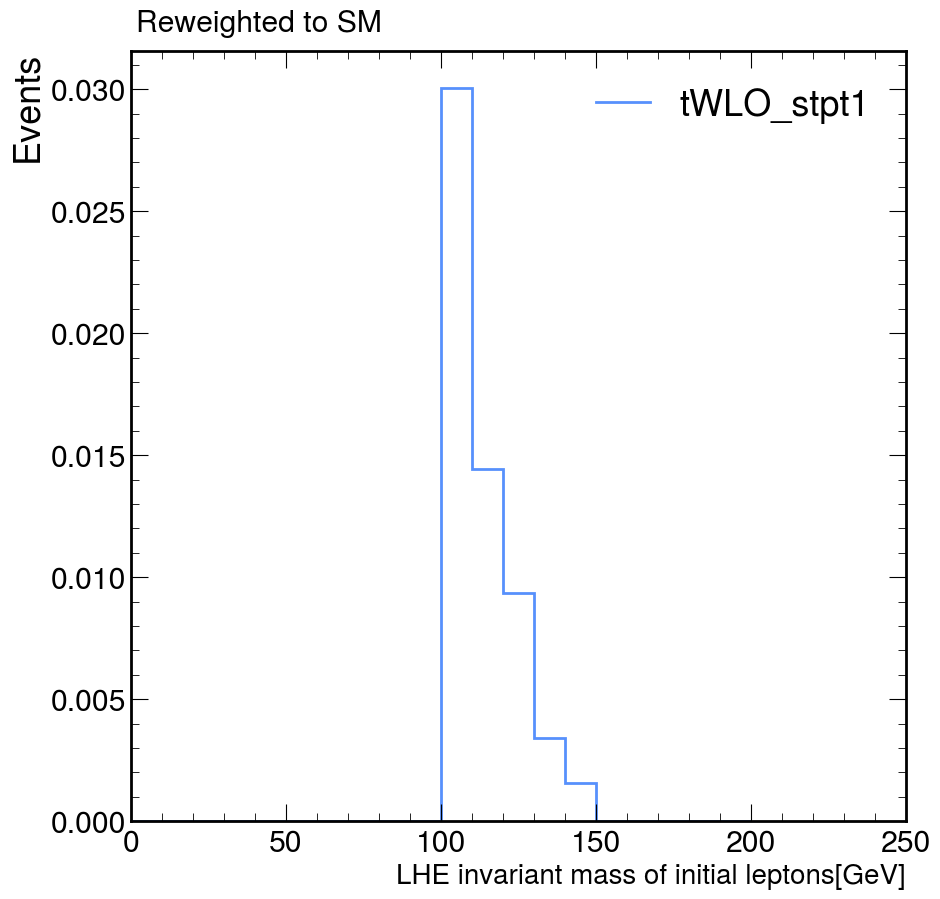

In [17]:
lhe_mmnl = tWLO_stpt1_LHEmmnl_sow['lhe_mmnl_100'].as_hist({})


fig, ax = plt.subplots()
lhe_mmnl.plot1d(ax=ax, stack=False, yerr=False, linewidth=2, label="tWLO_stpt1")

## Formatting
ax.legend(loc = 'upper right', fontsize = 'medium')
ax.set_ylabel("Events", fontsize='medium')
plt.figtext(0.13, 0.9, "Reweighted to SM", fontsize='small')
ax.set_xlim([0, 250])

# plt.close(fig)

In [56]:
savedir = "/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/"
standAlone = plotTools.read_MGstandalone_txt("/users/hnelson2/afs/mc_production/standAloneMG/tW_2q2l_test_xsec.txt")
for wc in standAlone.keys():
    stpt1_dict = make_samples_dict(file="/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt1_LHEmmnl_sow.pkl.gz", wc_name=wc, wc_max=10.0, hist_name='sow_mmnl_100')
    stpt2_dict = make_samples_dict(file="/users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tWLO_stpt2_LHEmmnl_sow.pkl.gz", wc_name=wc, wc_max=10.0, hist_name='sow_mmnl_100')
    
    # standalone_dict = make_scatter_list_oneWC(standAlone[wc], 5.63, 0.01903)
    standalone_dict = make_scatter_list_oneWC(standAlone[wc], 5.97, 0.02165)
    
    fig, ax = plt.subplots()
    ax.scatter(standalone_dict[0], standalone_dict[1], label = "MG standalone")
    ax.errorbar(standalone_dict[0], standalone_dict[1], yerr = standalone_dict[2], xerr = None, capsize=5, ls='none')
    ax.plot(stpt1_dict[0], stpt1_dict[1], label="stpt1")
    ax.plot(stpt2_dict[0], stpt2_dict[1], label="stpt2")

    ax.legend(loc='best', fontsize='medium') #bbox_to_anchor=(1.02, 0.5),
    ax.set_xlabel(wc, fontsize = 'large')
    ax.set_ylabel(r"$\sigma_{SMEFT} /\ \sigma_{SM}$", fontsize='large')
    ax.set_xlim([-10.0, 10.0])
    # fig.show()
    
    figname = f"LHEmmnl_quad1d_{wc}.png"
    fig.savefig(os.path.join(savedir,figname)) #bbox_inches='tight'
    print(f"saving plot to {os.path.join(savedir, figname)}")
    plt.close(fig)

saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cQl311.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cQl322.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cQl333.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cleQt3Re11.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cleQt3Re22.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cleQt3Re33.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cleQt1Re11.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cleQt1Re22.png
saving plot to /users/hnelson2/afs/ttbarEFT/analysis/mc_validation/tW_plots/1dquad/LHEmmnl_quad1d_cleQt1Re33